# Skupina B - Analýza výstavby dopravní infrastruktury v zemích Evropské Unie

Prvním krokem bude stažení potřebných dat. Níže jsou API odkazy na stažení dat.

In [1]:
railway_url = 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/ttr00003/1.0/*.*.*.*.*?c[freq]=A&c[tra_infr]=TOTAL&c[n_tracks]=TOTAL&c[unit]=KM&c[geo]=EU27_2020,BE,BG,CZ,DK,DE,EE,IE,EL,ES,FR,HR,IT,LV,LT,LU,HU,NL,AT,PL,PT,RO,SI,SK,FI,SE,LI,NO,CH,UK,BA,ME,MD,MK,GE,AL,RS,TR,UA,XK,CY,EA19,EA20,IS,MT&c[TIME_PERIOD]=2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023&compress=false&format=csvdata&formatVersion=1.0&lang=en&labels=label_only'
highway_url = 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/ttr00002/1.0/*.*.*.*?c[freq]=A&c[tra_infr]=MWAY&c[unit]=KM&c[geo]=EU27_2020,BE,BG,CZ,DK,DE,EE,IE,EL,ES,FR,HR,IT,CY,LV,LT,LU,HU,MT,NL,AT,PL,PT,RO,SI,SK,FI,SE,IS,LI,NO,CH,UK,BA,ME,MD,MK,GE,AL,RS,TR,UA,XK,EA19,EA20&c[TIME_PERIOD]=2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024&compress=false&format=csvdata&formatVersion=1.0&lang=en&labels=label_only'
population_url = 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/tps00001/1.0/*.*.*?c[freq]=A&c[indic_de]=JAN&c[geo]=EU27_2020,EA20,EA19,BE,BG,CZ,DK,DE,EE,IE,EL,ES,FR,FX,HR,IT,CY,LV,LT,LU,HU,MT,NL,AT,PL,PT,RO,SI,SK,FI,SE,IS,LI,NO,CH,UK,BA,ME,MD,MK,GE,AL,RS,TR,UA,XK,AD,BY,MC,RU,SM,AM,AZ&c[TIME_PERIOD]=2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025&compress=false&format=csvdata&formatVersion=1.0&lang=en&labels=label_only'

Definujme funkci pro jejich stažení.

In [2]:
import requests
import io

def download_file(url):
    response = requests.get(url)
    if response.status_code != 200:
        print(f'Failed to retrieve data, code: {response.status_code}')
        return None

    file = io.BytesIO(response.content)

    return file

Nyní data stáhneme a otevřeme pomocí knihovny Pandas.

In [3]:
import pandas as pd

railway_file = download_file(railway_url)
highway_file = download_file(highway_url)
population_file = download_file(population_url)

railway_data = pd.read_csv(railway_file)
highway_data = pd.read_csv(highway_file)
population_data = pd.read_csv(population_file)

Správnost načtení ověříme zobrazením hlaviček.

In [4]:
railway_data.head()

,DATAFLOW,LAST UPDATE,freq,tra_infr,n_tracks,unit,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG,CONF_STATUS
0,ESTAT:TTR00003(1.0),30/10/25 23:00:00,Annual,Total,Total,Kilometre,Albania,2012,353.0,i,NaN
1,ESTAT:TTR00003(1.0),30/10/25 23:00:00,Annual,Total,Total,Kilometre,Albania,2013,346.0,NaN,NaN
2,ESTAT:TTR00003(1.0),30/10/25 23:00:00,Annual,Total,Total,Kilometre,Albania,2014,346.0,NaN,NaN
3,ESTAT:TTR00003(1.0),30/10/25 23:00:00,Annual,Total,Total,Kilometre,Albania,2015,379.0,NaN,NaN
4,ESTAT:TTR00003(1.0),30/10/25 23:00:00,Annual,Total,Total,Kilometre,Albania,2016,334.0,NaN,NaN


In [5]:
highway_data.head()

,DATAFLOW,LAST UPDATE,freq,tra_infr,unit,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG,CONF_STATUS
0,ESTAT:TTR00002(1.0),14/11/25 23:00:00,Annual,Motorways,Kilometre,Albania,2013,0.0,NaN,NaN
1,ESTAT:TTR00002(1.0),14/11/25 23:00:00,Annual,Motorways,Kilometre,Albania,2014,0.0,NaN,NaN
2,ESTAT:TTR00002(1.0),14/11/25 23:00:00,Annual,Motorways,Kilometre,Albania,2015,0.0,NaN,NaN
3,ESTAT:TTR00002(1.0),14/11/25 23:00:00,Annual,Motorways,Kilometre,Albania,2016,0.0,NaN,NaN
4,ESTAT:TTR00002(1.0),14/11/25 23:00:00,Annual,Motorways,Kilometre,Albania,2017,0.0,NaN,NaN


In [6]:
population_data.head()

,DATAFLOW,LAST UPDATE,freq,indic_de,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG,CONF_STATUS
0,ESTAT:TPS00001(1.0),14/10/25 23:00:00,Annual,Population on 1 January - total,Andorra,2016,71732,NaN,NaN
1,ESTAT:TPS00001(1.0),14/10/25 23:00:00,Annual,Population on 1 January - total,Andorra,2018,74794,e,NaN
2,ESTAT:TPS00001(1.0),14/10/25 23:00:00,Annual,Population on 1 January - total,Andorra,2019,76177,NaN,NaN
3,ESTAT:TPS00001(1.0),14/10/25 23:00:00,Annual,Population on 1 January - total,Andorra,2020,77543,e,NaN
4,ESTAT:TPS00001(1.0),14/10/25 23:00:00,Annual,Population on 1 January - total,Andorra,2022,79535,NaN,NaN


**Nyní můžeme začít data analyzovat.**
Začneme tím, že z dat získáme pouze evropské státy.
Vynecháme tedy souhrnná data.

In [7]:
population_data['geo'].unique()

array(['Andorra', 'Albania', 'Armenia', 'Austria', 'Azerbaijan',
       'Bosnia and Herzegovina', 'Belgium', 'Bulgaria', 'Belarus',
       'Switzerland', 'Cyprus', 'Czechia', 'Germany', 'Denmark',
       'Euro area - 19 countries  (2015-2022)',
       'Euro area – 20 countries (from 2023)', 'Estonia', 'Greece',
       'Spain', 'European Union - 27 countries (from 2020)', 'Finland',
       'France', 'Georgia', 'Croatia', 'Hungary', 'Ireland', 'Iceland',
       'Italy', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Latvia',
       'Monaco', 'Moldova', 'Montenegro', 'North Macedonia', 'Malta',
       'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Serbia',
       'Russia', 'Sweden', 'Slovenia', 'Slovakia', 'San Marino',
       'Türkiye', 'Ukraine', 'United Kingdom', 'Kosovo*'], dtype=object)

Vidíme, že souhrnná data jsou tam, kde v atributu *geo* je nějaká závorka. Vybereme tedy všechna kromě těchto dat. 

In [8]:
highway_data = highway_data[~highway_data['geo'].str.contains(r'[()]', regex=True)]
railway_data = railway_data[~railway_data['geo'].str.contains(r'[()]', regex=True)]
population_data = population_data[~population_data['geo'].str.contains(r'[()]', regex=True)]

Tím jsme se zbavili souhrnných dat.

In [9]:
population_data['geo'].unique()

array(['Andorra', 'Albania', 'Armenia', 'Austria', 'Azerbaijan',
       'Bosnia and Herzegovina', 'Belgium', 'Bulgaria', 'Belarus',
       'Switzerland', 'Cyprus', 'Czechia', 'Germany', 'Denmark',
       'Estonia', 'Greece', 'Spain', 'Finland', 'France', 'Georgia',
       'Croatia', 'Hungary', 'Ireland', 'Iceland', 'Italy',
       'Liechtenstein', 'Lithuania', 'Luxembourg', 'Latvia', 'Monaco',
       'Moldova', 'Montenegro', 'North Macedonia', 'Malta', 'Netherlands',
       'Norway', 'Poland', 'Portugal', 'Romania', 'Serbia', 'Russia',
       'Sweden', 'Slovenia', 'Slovakia', 'San Marino', 'Türkiye',
       'Ukraine', 'United Kingdom', 'Kosovo*'], dtype=object)

Zobrazme, jaké mají jednotlivé státy celkovou délku infrastruktur v absolutních hodnotách.

In [10]:
import matplotlib.pyplot as plt

def plot_absolute(df):
    plt.figure(figsize=(12, 6))
    
    for geo, group in df.groupby("geo"):
        plt.plot(group["TIME_PERIOD"], group["OBS_VALUE"], label=geo)
    
    plt.xlabel("Rok")
    plt.ylabel("Délka [km]")
    plt.legend(title="Státy", bbox_to_anchor=(1.05, 1), loc="right")
    plt.show()

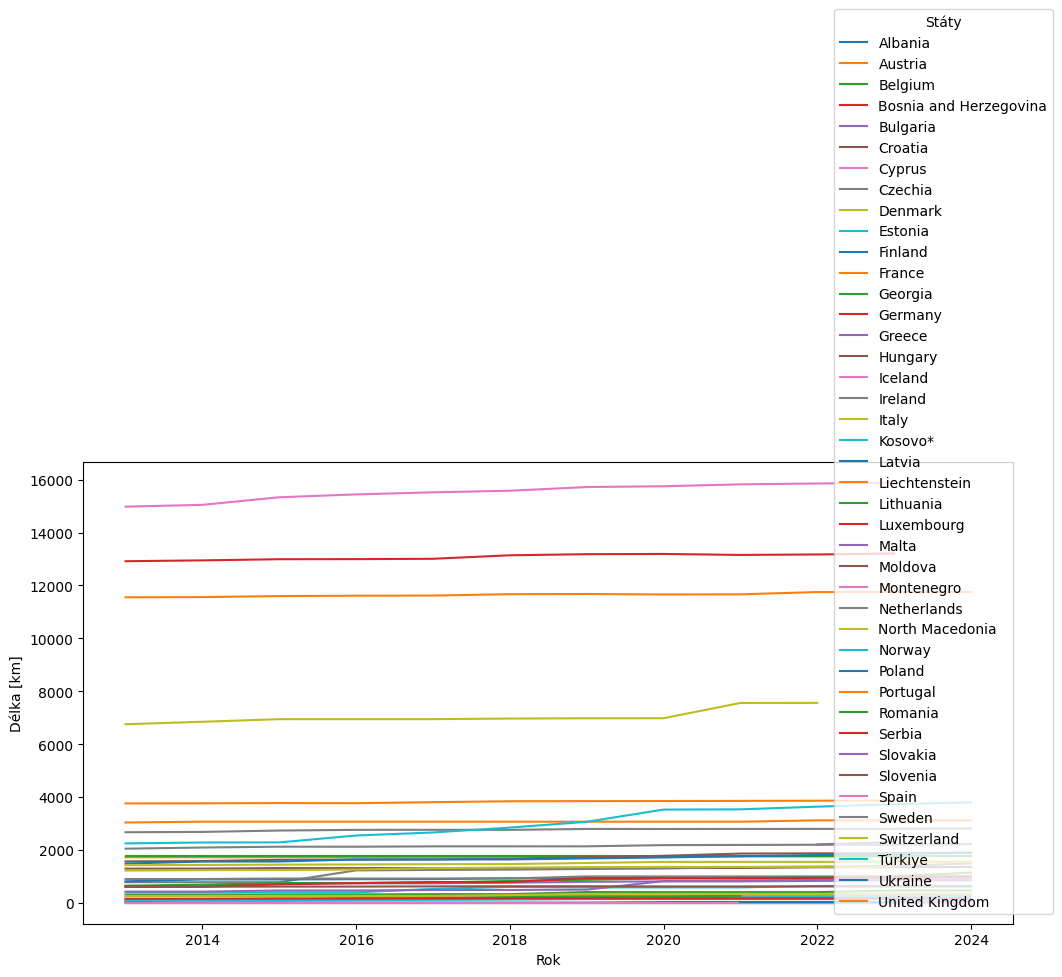

In [11]:
plot_absolute(highway_data)

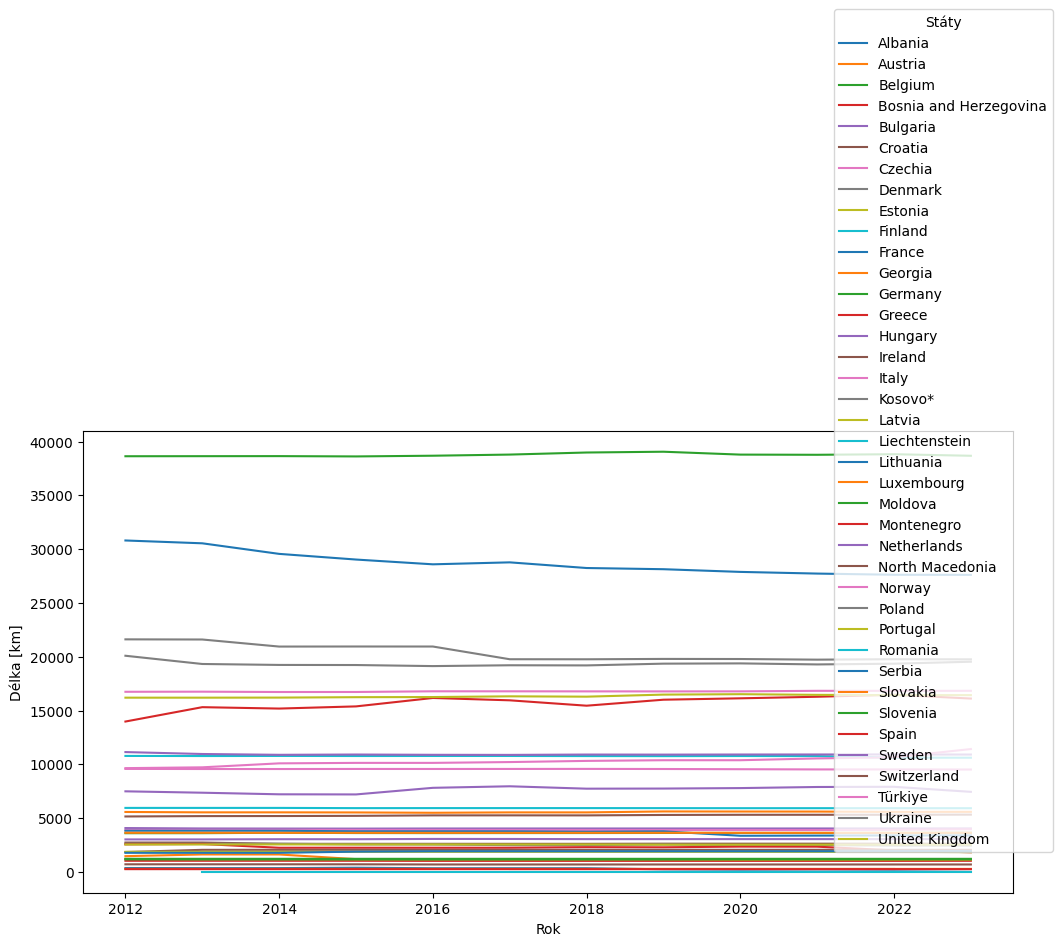

In [12]:
plot_absolute(railway_data)

Tím však nezjistíme nic o tom, jak se kterým státům daří. Velké státy mají více infrastruktury, vypočítejme tedy, kolik km infrastruktury připadne na 1000 obyvatel.

In [13]:
def infrastructure_per_cap(df_infra, df_pop):
    data = pd.DataFrame({
        "geo": [],
        "TIME_PERIOD": [],
        "OBS_VALUE": []
    })

    # iterrows() iteruje přes řádky
    for _, row in df_infra.iterrows():
        geo = row["geo"]
        year = row["TIME_PERIOD"]
        infra = row["OBS_VALUE"]
        pop_row = df_pop[(df_pop["geo"] == geo) & (df_pop["TIME_PERIOD"] == year)]

        if pop_row.empty:
            continue

        population = pop_row.iloc[0]["OBS_VALUE"]

        index = infra / (population / 1000)

        new_row = pd.DataFrame({
                "geo": [geo],
                "TIME_PERIOD": [year],
                "OBS_VALUE": [index]
            })
        data = pd.concat([data, new_row], ignore_index=True)
            
    return data

In [14]:
highway_pc = infrastructure_per_cap(highway_data, population_data)
railway_pc = infrastructure_per_cap(railway_data, population_data)

Výsledky zobrazme do grafů.

In [15]:
def plot_index(df, index_label):
    plt.figure(figsize=(12, 6))
    
    for geo, group in df.groupby("geo"):
        plt.plot(group["TIME_PERIOD"], group["OBS_VALUE"], label=geo)
    
    plt.xlabel("Rok")
    plt.ylabel(index_label)
    plt.legend(title="Státy", bbox_to_anchor=(1.05, 1), loc="right")
    plt.show()

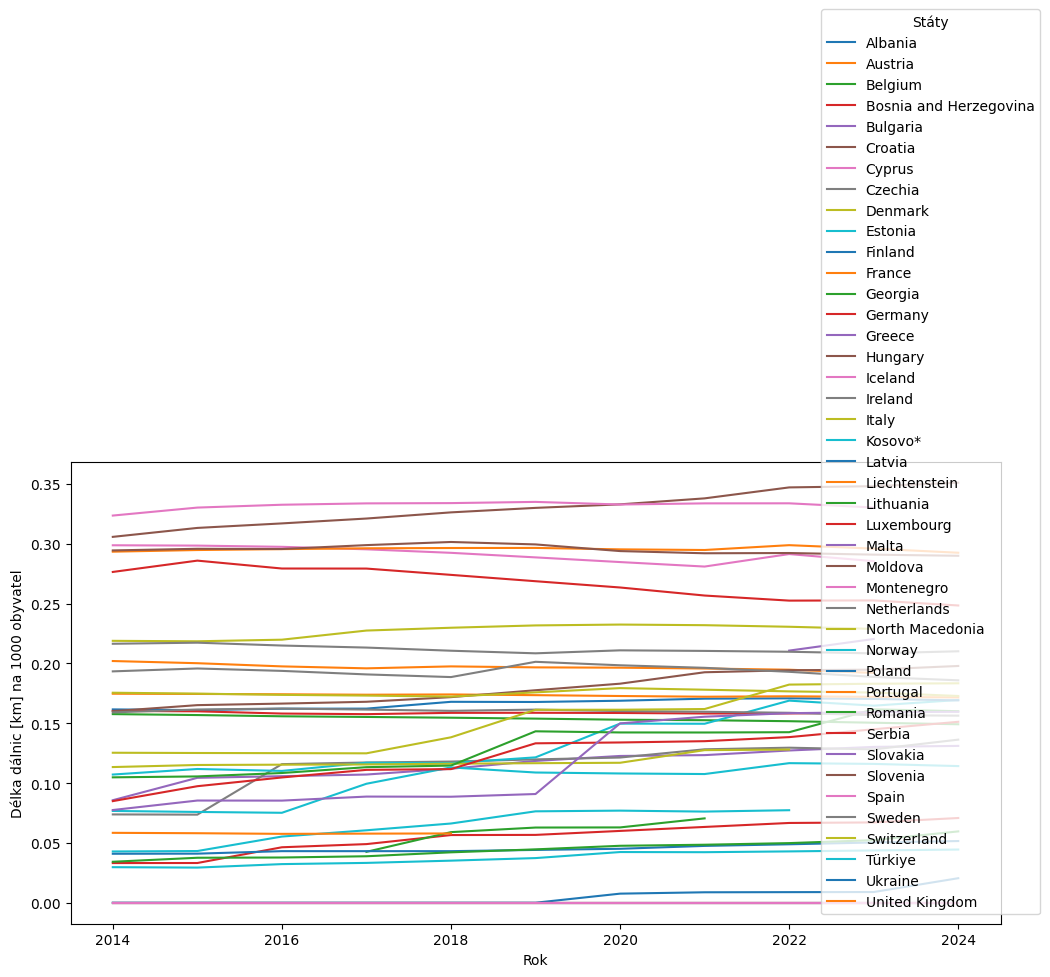

In [16]:
plot_index(highway_pc, "Délka dálnic [km] na 1000 obyvatel")

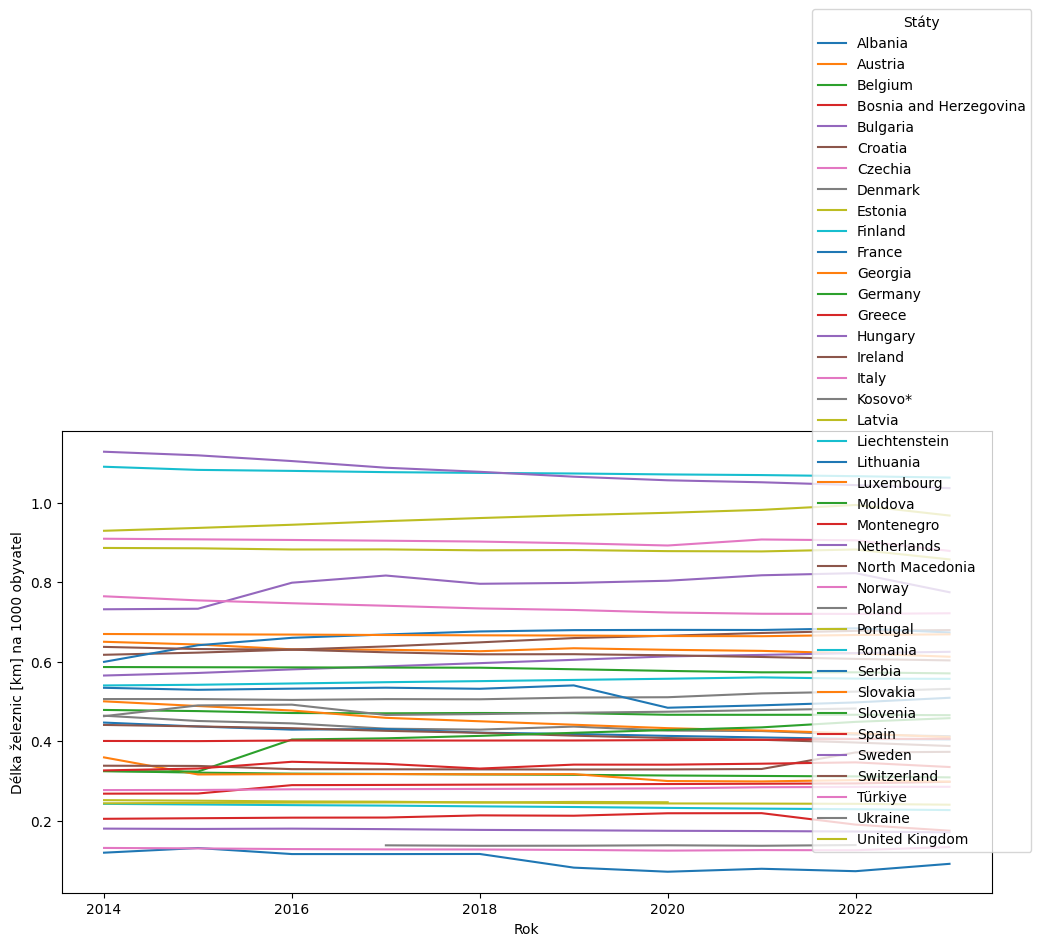

In [17]:
plot_index(railway_pc, "Délka železnic [km] na 1000 obyvatel")

Zobrazíme také histogram z posledního roku, kdy máme pro Českou republiku data, abychom získali lepší pojem o rozložení hodnot.

In [18]:
def show_hist(df):
    plt.hist(df["OBS_VALUE"], bins=7)
    
    plt.xlabel("Hodnota")
    plt.ylabel("Počet států")
    plt.show()

Zobrazíme data pro poslední rok, kdy ještě máme data pro Českou republiku.

Data z roku 2024, Česká republika má hodnotu 0.13632


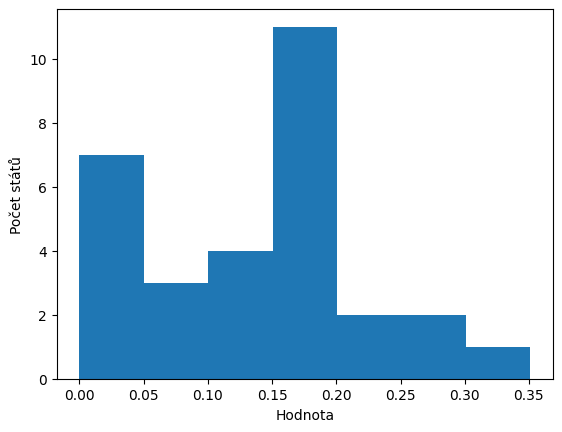

In [20]:
year_hw = highway_pc[highway_pc["geo"] == "Czechia"]["TIME_PERIOD"].max()
value_hw = highway_pc[(highway_pc["geo"] == "Czechia") & (highway_pc["TIME_PERIOD"] == year_hw)]["OBS_VALUE"]

print(f"Data z roku {int(year_hw)}, Česká republika má hodnotu {value_hw.squeeze().round(5)}")

show_hist(highway_pc[highway_pc["TIME_PERIOD"] == year_hw])

Data z roku 2023, Česká republika má hodnotu 0.87869


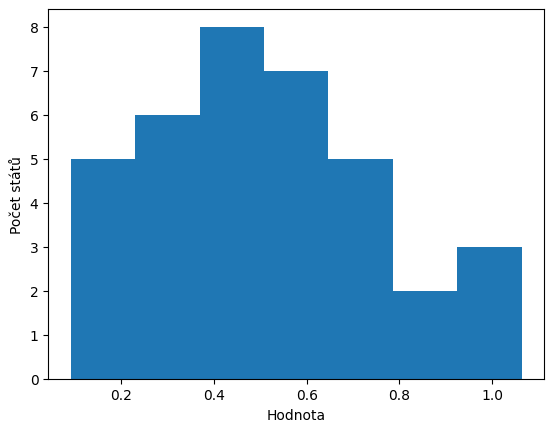

In [21]:
year_rw = railway_pc[railway_pc["geo"] == "Czechia"]["TIME_PERIOD"].max()
value_rw = railway_pc[(railway_pc["geo"] == "Czechia") & (railway_pc["TIME_PERIOD"] == year_rw)]["OBS_VALUE"]

print(f"Data z roku {int(year_rw)}, Česká republika má hodnotu {value_rw.squeeze().round(5)}")

show_hist(railway_pc[railway_pc["TIME_PERIOD"] == year_rw])

Zobrazíme ještě žebříček států v těchto ukazatelích.

In [22]:
highway_pc_ranking = highway_pc[highway_pc["TIME_PERIOD"] == year_hw].sort_values("OBS_VALUE", ascending=False)
highway_pc_ranking

,geo,TIME_PERIOD,OBS_VALUE
162,Croatia,2024.0,0.351116
335,Portugal,2024.0,0.292583
379,Slovenia,2024.0,0.290037
236,Luxembourg,2024.0,0.248493
368,Sweden,2024.0,0.210203
173,Hungary,2024.0,0.197921
184,Ireland,2024.0,0.185923
280,North Macedonia,2024.0,0.183436
60,Switzerland,2024.0,0.172836
146,France,2024.0,0.171627


In [23]:
railway_pc_ranking = railway_pc[railway_pc["TIME_PERIOD"] == year_rw].sort_values("OBS_VALUE", ascending=False)
railway_pc_ranking

,geo,TIME_PERIOD,OBS_VALUE
127,Finland,2023.0,1.063090
327,Sweden,2023.0,1.036539
227,Latvia,2023.0,0.967653
67,Czechia,2023.0,0.878686
97,Estonia,2023.0,0.857320
167,Hungary,2023.0,0.774708
277,Norway,2023.0,0.721809
157,Croatia,2023.0,0.679582
207,Lithuania,2023.0,0.673473
347,Slovakia,2023.0,0.668841
